# What is the task we will perform in this notebook?

 **Classification Task:**

 Objective: Predict whether a person is likely to seek mental health treatment (treatment column: yes/no)

 Input Features: Workplace support, past diagnosis, family history, leave policies, etc.
 
 Algorithms to Try: Logistic Regression, Random Forest, XGBoost, SVM, etc.
 
 Evaluation: Accuracy, ROC-AUC, Confusion Matrix, F1 Score

So let's embark..

# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import joblib

# Loading and reading the input dataset

In [3]:
df=pd.read_csv('data/cleaned_survey_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1228 non-null   object
 1   Age                        1228 non-null   int64 
 2   Country                    1228 non-null   object
 3   state                      730 non-null    object
 4   self_employed              1228 non-null   int64 
 5   family_history             1228 non-null   object
 6   treatment                  1228 non-null   object
 7   work_interfere             1228 non-null   object
 8   no_employees               1228 non-null   object
 9   remote_work                1228 non-null   object
 10  tech_company               1228 non-null   object
 11  benefits                   1228 non-null   object
 12  care_options               1228 non-null   object
 13  wellness_program           1228 non-null   object
 14  seek_hel

# A few more requisite libraries

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


This time we use OneHotEncoder instead of LabelEncoder to get categorical features as integral

In [5]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown="ignore")

In [6]:
#X=df[['benefits_encoded','co_encoded','fh_encoded','leave_encoded','wp_encoded','seek_help_encoded','mhi_encoded']]
#y=df['treatment_encoded']

# Libraries to build a Pipeline with a ColumnTransformer

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Defining numerical and categorical features separately from the dataset to feed into the pipeline

In [8]:
cat_features=['benefits','care_options','family_history','leave','wellness_program','seek_help','mental_health_interview']
num_features=['Gender_encoded','ages_encoded']

# And defining X and y from these numerical and categorical features

In [9]:
X=df[cat_features+num_features]
y=df['treatment_encoded']

# Checking distribution in full dataset

treatment_encoded
1    622
0    606
Name: count, dtype: int64 

Proportion:
treatment_encoded
1    0.506515
0    0.493485
Name: proportion, dtype: float64


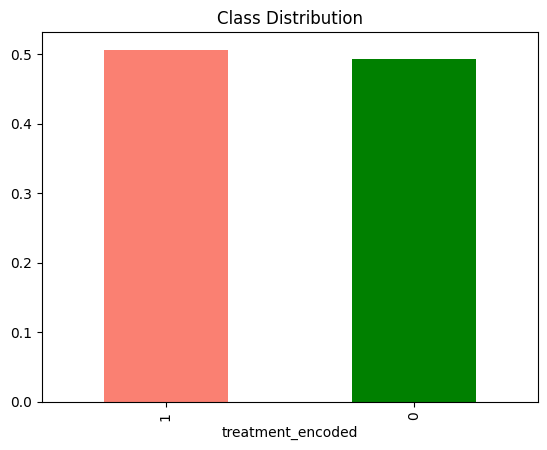

In [10]:
y.value_counts(normalize=True).plot(kind='bar', color=['salmon', 'green'], title='Class Distribution')
print(y.value_counts(), "\n\nProportion:")
print(y.value_counts(normalize=True))


# Now we split the dataset into training and test data

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

# Applying preprocessing on the categorical and the numerical features

In [12]:
num_trans=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cate_trans=Pipeline(steps=[('onehotenco',OneHotEncoder(handle_unknown="ignore"))])

# Plugging together the prior built transformers into preprocessor

In [13]:
preprocessor=ColumnTransformer(transformers=[("num",num_trans,num_features),("cate",cate_trans,cat_features)])

# And finally we build a pipeline with the model Logistic Regression

In [14]:
pipeline=Pipeline(steps=[("preprocessor",preprocessor),("classifier",LogisticRegression(max_iter=1000))])

# Now we make predictions on the target feature using the pipeline

In [15]:
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

# Now we import evaluation metrics from scikit-learn

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

Accuracy score for Logistic Regression

In [17]:
accu=accuracy_score(y_test,y_pred)
print(f"Accuracy: {accu:.3f}")

Accuracy: 0.695


Here it can be inferred that the model classifies around 7 out of 10 people correctly whether they chose to seek treatment or not, given the accuracy is aorund 69.5% (~ 70%).

So the model learns a few patterns from the input features, but it is still not excellent in terms of making predictions.

The model also skips few important signals about people who were classified wrongly and might be in need of urgent requirement for treatment in this case.

ROC-AUC score:

'Receiver Operating Characteristic - Area under curve' measures model's ability to distinguish between classes.

In [18]:
y_proba=pipeline.predict_proba(X_test)
roc_auc=roc_auc_score(y_test,y_pred)
print(f"ROC AUC score:{roc_auc:.4f}")

ROC AUC score:0.6907


On average the model assigns a higher score to positive case of whether the person sought treatment for mental health problem than a negative one around ~69% of time.

The Confusion Matrix

In [19]:
cm=confusion_matrix(y_test,y_pred)
print(f"Confusion Matrix: \n{cm}")

Confusion Matrix: 
[[ 71  38]
 [ 37 100]]


Rows : Actual classes

Columns: Predicted classes

Assuming first row and column is for 0 i.e. not seeking treatment, and the 2nd one for 1 i.e. taking tgreatment, We get around 71 True negatives and 100 True positives.

Additionally, we got 38 False positives, and 37 False negatives. **Here we can infer that the model isn't heavily biased towards one class either 0 or 1 and the errors are balanced.**

And the f1 score

In [20]:
f1=f1_score(y_test,y_pred)
print(f"F-1 Score: {f1:.4f}")

F-1 Score: 0.7273


This score is the Harmonic Mean of precision and recall, where precision is 0.724 and recall is 0.730. We get f1 score equal to ~0.727 which is a moderate one. The model performs pretty much same when it comes to catching Yes cases and avoiding false alarms in case of No case.

# Now we import the libraries required to execute other algorithms

In [21]:
import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Plugging these models into the pipeline along with preprocessor

In [22]:
models={
    'Random Forest': Pipeline([('preprocessor',preprocessor),('classifier',RandomForestClassifier(n_estimators=100))]),

    'SVM':Pipeline([('preprocessor',preprocessor),('classifier',SVC(probability=True))]),

    'XGBoost':Pipeline([('preprocessor',preprocessor),('classifier',XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
}

# And here's a look at the evaluation metrics for these models

In [23]:
from sklearn.metrics import classification_report
for name,model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_proba1=model.predict_proba(X_test)[:, 1]
    rocauc_score=roc_auc_score(y_test, y_proba1)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    print("F-1 score:", f1_score(y_test, y_pred))
    print("ROC-AUC score:",round(rocauc_score, 4))
    print("Classification Report:\n",classification_report(y_test,y_pred))


 Model: Random Forest
Accuracy: 0.6016260162601627
Confusion Matrix:
 [[75 34]
 [64 73]]
F-1 score: 0.5983606557377049
ROC-AUC score: 0.6461
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.69      0.60       109
           1       0.68      0.53      0.60       137

    accuracy                           0.60       246
   macro avg       0.61      0.61      0.60       246
weighted avg       0.62      0.60      0.60       246


 Model: SVM
Accuracy: 0.6991869918699187
Confusion Matrix:
 [[ 72  37]
 [ 37 100]]
F-1 score: 0.7299270072992701
ROC-AUC score: 0.7321
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66       109
           1       0.73      0.73      0.73       137

    accuracy                           0.70       246
   macro avg       0.70      0.70      0.70       246
weighted avg       0.70      0.70      0.70       246


 Model: XGBoost


c:\Users\anudi\Desktop\Capstone Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:45:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6056910569105691
Confusion Matrix:
 [[73 36]
 [61 76]]
F-1 score: 0.6104417670682731
ROC-AUC score: 0.6649
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.67      0.60       109
           1       0.68      0.55      0.61       137

    accuracy                           0.61       246
   macro avg       0.61      0.61      0.61       246
weighted avg       0.62      0.61      0.61       246



# Final Inferences:

Out of the 3 models we trained above, SVM performs the best with it having an accuracy of 69.9% (~70%), while RandomForest and XGBoost have pretty much equal accuracy of around 60.5%. So the target is a bit noisy feature and none of the 3 models manages to perform spectacularly well while doing the classification task.

SVM is better known to handle smaller datasets with higher dimensions when the decision boundaries are complex, and since the cleaned dataset is not too large so that could the reason why we see the SVM performing fairly well. However, Logistic Regression and especially RandomForest might be underfitting here.

The little weaker performance of the other models like RandomForest and XGBoost could be due to the featueres not having strong splits and there being weaker signals. Also as we don't perform hyperparameter tuning (due to time constraints), we might not be getting the best performance with the default parameters used, and they might be under/over fitting.

In terms of the ROC-AUC score, SVM is ahead od the other 3 models which means the class distribution is done more correctly in this case. It finds a better decision boundary in case of SVM than Logistic Regression and Ensemble tree based models. Also since the no. of features are high (high dimensional data) so SVM handles it better in high dimensional settings, with features on different scales which we scale using Standard Scaler.

# Now we save the pipeline containing the estimator Logistic Regression

In [24]:
joblib.dump(pipeline, 'logistic_regression.pkl')

['logistic_regression.pkl']

# And also the pipeline named 'models' using the other 3 models

In [25]:
joblib.dump(models, 'classification_tasks.pkl')

['classification_tasks.pkl']

In [26]:
import joblib

models = joblib.load("models/classification_tasks.pkl")
print(type(models))
print(models)


<class 'dict'>
{'Random Forest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Gender_encoded',
                                                   'ages_encoded']),
                                                 ('cate',
                                                  Pipeline(steps=[('onehotenco',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['benefits', 'care_options',
                                                   'family_history